In [1]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'numpy'

### Data Generation

In [ ]:
def createDataPoints(centroidLocation, numSamples, clusterDeviation):
    X, y = make_blobs(n_samples=numSamples, centers=centroidLocation, cluster_std=clusterDeviation)
    
    X = StandardScaler().fit_transform(X)
    return X, y

In [ ]:
X, y = createDataPoints([[4, 3], [2, -1], [-1, 4]], 1500, 0.5)
X[0:5]

array([[-0.11751323, -1.37107846],
       [ 0.98838108,  0.65312385],
       [ 0.82098312,  0.73439912],
       [-1.18098743,  1.07924301],
       [-0.42614443, -0.95382739]])

In [ ]:
y[0:5]

array([1, 0, 0, 2, 1])

## Modeling

Density-Based Spatial Clustering of Applications with Noise (DBSCAN). 

It word based on 2 parameters: Epsilon and Minimum Points\
**Epsilon** determine a specified radius that if includes enough number of points within, we call it dense area\
**minimumSamples** determine the minimum number of data points we want in a neighborhood to define a cluster

In [ ]:
epsilon = 0.3 
minimumSamples = 7
db = DBSCAN(eps=epsilon, min_samples = minimumSamples).fit(X)
labels = db.labels_
labels

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

## Distinguish outliers

Replace all elements with 'True' in core_samples_mask that are in the cluster, 'False' if the points are outliers.

In [ ]:
db.core_sample_indices_

array([   0,    1,    2, ..., 1497, 1498, 1499], dtype=int64)

In [ ]:
# first, create an array of booleans using the labels from db.
core_samples_mask = np.zeros_like(db.labels_, dtype=bool) # numpy array of all false
core_samples_mask[db.core_sample_indices_] = True
core_samples_mask

uniq, counts = np.unique(core_samples_mask, return_counts=True)
uniq, counts

(array([False,  True]), array([   8, 1492], dtype=int64))

In [ ]:
# Get the indices where the array is False
false_indices = np.where(core_samples_mask == False)[0]

# Print the false indices
print(false_indices)

[ 120  167  170  504 1002 1205 1272 1359]


In [ ]:
db.core_sample_indices_.size

1492

In [ ]:
len(set(labels))

4

In [ ]:
# number of clusters in labels, ignoring noise if present
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

3

In [ ]:
# remove repetition in labels by turning it into a set
unique_labels = set(labels)
unique_labels

{-1, 0, 1, 2}

### Data visualization

In [ ]:
# create colors for the clusters
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

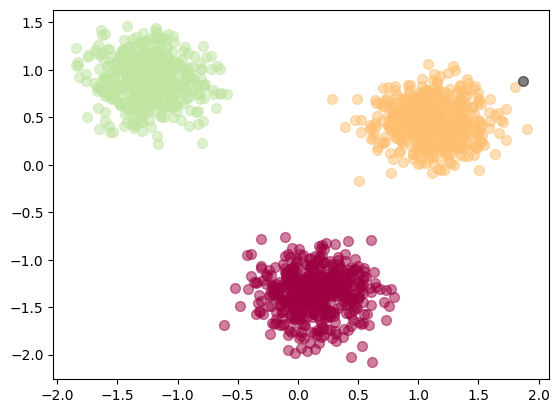

In [ ]:
# plot the points with colors
for k, col in zip(unique_labels, colors):
    if k == -1:
        # black used for noise
        col = 'k'
    
    class_member_mask = (labels == k)
    
    # plot the datapoints that are clustered
    xy = X[class_member_mask & core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1], s=50, c=[col], marker=u'o', alpha=0.5)
    
    # plot the outliers
    xy = X[class_member_mask & ~core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1], s=50, c=[col], marker=u'o', alpha = 0.5)

C:\Users\angel\AppData\Local\Temp\ipykernel_14120\328517362.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X[my_members, 0], X[my_members, 1], c=col, marker=u'o', alpha=0.5)


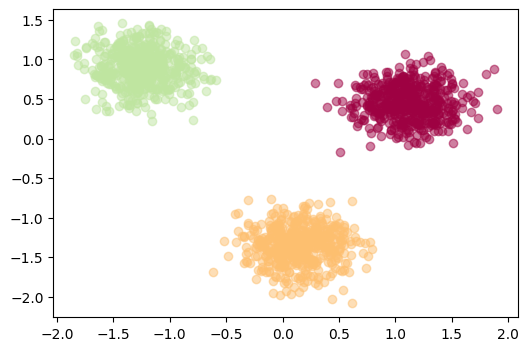

In [ ]:
# Practice 3 cluster usign k-Means
from sklearn.cluster import KMeans
k = 3
k_means3 = KMeans(init = "k-means++", n_clusters = k, n_init = 12)
k_means3.fit(X)
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
for k, col in zip(range(k), colors):
    my_members = (k_means3.labels_== k)
    plt.scatter(X[my_members, 0], X[my_members, 1], c=col, marker=u'o', alpha=0.5)
plt.show()


# Weather Station Clustering using DBSCAN & scikit-learn
*   Overview data
*   Data cleaning
*   Data selection
*   Clusteing

## Load dataset

In [ ]:
import pandas as pd
import numpy as np

filename = 'weather-stations20140101-20141231.csv'

pdf = pd.read_csv(filename)
pdf.head(5)

,Stn_Name,Lat,Long,Prov,Tm,DwTm,D,Tx,DwTx,Tn,...,DwP,P%N,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Stn_No
0,CHEMAINUS,48.935,-123.742,BC,8.2,0.0,NaN,13.5,0.0,1.0,...,0.0,NaN,0.0,12.0,NaN,NaN,NaN,273.3,0.0,1011500
1,COWICHAN LAKE FORESTRY,48.824,-124.133,BC,7.0,0.0,3.0,15.0,0.0,-3.0,...,0.0,104.0,0.0,12.0,NaN,NaN,NaN,307.0,0.0,1012040
2,LAKE COWICHAN,48.829,-124.052,BC,6.8,13.0,2.8,16.0,9.0,-2.5,...,9.0,NaN,NaN,11.0,NaN,NaN,NaN,168.1,0.0,1012055
3,DISCOVERY ISLAND,48.425,-123.226,BC,NaN,NaN,NaN,12.5,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1012475
4,DUNCAN KELVIN CREEK,48.735,-123.728,BC,7.7,2.0,3.4,14.5,2.0,-1.0,...,2.0,NaN,NaN,11.0,NaN,NaN,NaN,267.7,0.0,1012573


## Cleaning

In [ ]:
pdf = pdf[pd.notnull(pdf["Tm"])]
pdf = pdf.reset_index(drop=True)
pdf.head()

,Stn_Name,Lat,Long,Prov,Tm,DwTm,D,Tx,DwTx,Tn,...,DwP,P%N,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Stn_No
0,CHEMAINUS,48.935,-123.742,BC,8.2,0.0,NaN,13.5,0.0,1.0,...,0.0,NaN,0.0,12.0,NaN,NaN,NaN,273.3,0.0,1011500
1,COWICHAN LAKE FORESTRY,48.824,-124.133,BC,7.0,0.0,3.0,15.0,0.0,-3.0,...,0.0,104.0,0.0,12.0,NaN,NaN,NaN,307.0,0.0,1012040
2,LAKE COWICHAN,48.829,-124.052,BC,6.8,13.0,2.8,16.0,9.0,-2.5,...,9.0,NaN,NaN,11.0,NaN,NaN,NaN,168.1,0.0,1012055
3,DUNCAN KELVIN CREEK,48.735,-123.728,BC,7.7,2.0,3.4,14.5,2.0,-1.0,...,2.0,NaN,NaN,11.0,NaN,NaN,NaN,267.7,0.0,1012573
4,ESQUIMALT HARBOUR,48.432,-123.439,BC,8.8,0.0,NaN,13.1,0.0,1.9,...,8.0,NaN,NaN,12.0,NaN,NaN,NaN,258.6,0.0,1012710


## Visualization

In [2]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

llon=-140
ulon=-50
llat=40
ulat=65

pdf = pdf[(pdf['Long'] > llon) & (pdf['Long'] < ulon) & (pdf['Lat'] > llat) &(pdf['Lat'] < ulat)]

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
# my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To collect data based on stations        

xs,ys = my_map(np.asarray(pdf.Long), np.asarray(pdf.Lat))
pdf['xm']= xs.tolist()
pdf['ym'] =ys.tolist()

#Visualization1
for index,row in pdf.iterrows():
#   x,y = my_map(row.Long, row.Lat)
   my_map.plot(row.xm, row.ym,markerfacecolor =([1,0,0]),  marker='o', markersize= 5, alpha = 0.75)
#plt.text(x,y,stn)
plt.show()



FileNotFoundError: [WinError 2] The system cannot find the file specified: 'C:\\Users\\angel\\AppData\\Roaming\\Python\\Python310\\site-packages\\matplotlib.libs'

## Clustering of stations based on their location

In [ ]:
from sklearn.cluster import DBSCAN 
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = pdf[['xm', 'ym']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN 
db = DBSCAN(eps=0.15, min_samples=10).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices] = True
labels = db.labels_
pdf["Clus_Db"] = labels

realClusterNum = len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels))

# a sample of clusters
pdf[["Stn_Name", "Tx", "Tm", "Clus_Db"]].head()

In [ ]:
set(labels)

## Visualization of clusters based on location

In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
#my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))



#Visualization1
for clust_number in set(labels):
    c=(([0.4,0.4,0.4]) if clust_number == -1 else colors[np.int(clust_number)])
    clust_set = pdf[pdf.Clus_Db == clust_number]                    
    my_map.scatter(clust_set.xm, clust_set.ym, color =c,  marker='o', s= 20, alpha = 0.85)
    if clust_number != -1:
        cenx=np.mean(clust_set.xm) 
        ceny=np.mean(clust_set.ym) 
        plt.text(cenx,ceny,str(clust_number), fontsize=25, color='red',)
        print ("Cluster "+str(clust_number)+', Avg Temp: '+ str(np.mean(clust_set.Tm)))

## Clustering of stations based on their location, mean, max, and min temp

In [ ]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = pdf[['xm','ym','Tx','Tm','Tn']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
pdf["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# A sample of clusters
pdf[["Stn_Name","Tx","Tm","Clus_Db"]].head(5)

KeyError: "['xm', 'ym'] not in index"

## Viz of clusters based on location and temp

In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
#my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))



#Visualization1
for clust_number in set(labels):
    c=(([0.4,0.4,0.4]) if clust_number == -1 else colors[np.int(clust_number)])
    clust_set = pdf[pdf.Clus_Db == clust_number]                    
    my_map.scatter(clust_set.xm, clust_set.ym, color =c,  marker='o', s= 20, alpha = 0.85)
    if clust_number != -1:
        cenx=np.mean(clust_set.xm) 
        ceny=np.mean(clust_set.ym) 
        plt.text(cenx,ceny,str(clust_number), fontsize=25, color='red',)
        print ("Cluster "+str(clust_number)+', Avg Temp: '+ str(np.mean(clust_set.Tm)))

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'